In [1]:
import os.path
import sys
import django
sys.path.append('/home/galm/software/nacsos/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()
import scoping
from scoping.models import *

import pandas as pd
from buscarpy import retrospective_h0, recall_frontier

BASE_DIR=/home/galm/software/nacsos/BasicBrowser
Multicore TSNE not installed, tsne maps will not be able to be calculated


## Initial project

In [2]:
django.db.connection.close()
# Get the query
q = Query.objects.get(pk=10997)
new_q = Query.objects.get(pk=11877)

dids = set(Doc.objects.filter(query__in=[q], content__iregex='\w').values_list('pk', flat=True))

import statistics

django.db.connection.close()

def mode_na(x):
    v, c = np.unique(x, return_counts=True)
    if v.shape[0] == 1:
        return v[0]
    idx = np.argsort(c)[::-1]
    if c[idx[0]] > c[idx[1]]:
        return v[idx[0]]
    else:
        return 3
    
columns = [
    'id',
    'PY',
    'content',
    'title',
    'tslug',
    'wosarticle__de',
    'wosarticle__wc'
]

# Majority ratings
dos = DocOwnership.objects.filter(
    #query__project=q.project, 
    query__in=[q],
    relevant__gt=0,
    doc__content__iregex='\w'
)

dodf = pd.DataFrame.from_dict(dos.order_by('finish').values(
    'id','doc_id','user__username','relevant'
))
dodf.loc[dodf['relevant']==2,'relevant'] = 0
dodf.loc[dodf['relevant']==3,'relevant'] = 3

seen_df = dodf.groupby('doc_id').agg(lambda x: mode_na(x)).reset_index()[['doc_id','relevant']].rename(columns={"doc_id":"id"})
seen_df['seen'] = 1
seen_df.loc[pd.isna(seen_df['relevant']),'seen'] = np.NaN

ddf = pd.DataFrame.from_dict(
    Doc.objects.filter(pk__in=seen_df['id']).values(*columns)
)
seen_df = pd.merge(ddf,seen_df)

print(seen_df.shape)

for l, v in zip(['yes','no','maybe'],[1,0,3]):
    n = seen_df[seen_df['relevant']==v].shape[0]
    print(f'{n} documents with label {l}')

seen_df['relevant'] = seen_df['relevant'].replace(3,1)
seen_df.head()

unseen_docs = Doc.objects.filter(
    id__in=dids,
    content__iregex='\w',
).exclude(pk__in=seen_df['id'])

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = np.NaN
unseen_df['seen'] = 0
unseen_df['random_sample'] = 0

print(unseen_df.shape)
unseen_df.head()

# Here are the labels in the order they were created
dos = (pd.DataFrame.from_dict(DocOwnership.objects.filter(query__in=[q], relevant__gt=0).order_by('id').values('id','doc_id'))
       .groupby('doc_id')
       .first()
       .sort_values('id')
       .reset_index()
       .reset_index()
       .drop(columns="id")
       .rename(columns={"doc_id":"id","index":"order"})
      )
dos.head()

seen_df = seen_df.merge(dos,how="left").sort_values('order').reset_index(drop=True)
seen_df.head()

df = pd.concat([seen_df, unseen_df]).reset_index(drop=True)
seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']!=1].index
print(df.shape)
df.head()

(3078, 9)
144 documents with label yes
2934 documents with label no
0 documents with label maybe
(25468, 10)
(28546, 11)


,id,PY,content,title,tslug,wosarticle__de,wosarticle__wc,relevant,seen,order,random_sample
0,268305,2013.0,We show that two simple and nonintrusive 'nudg...,'Nudging' hotel guests to reduce food waste as...,nudginghotelgueststoreducefoodwasteasawinwinen...,Field experiment; Food waste; Behavioral econo...,[Economics],1.0,1.0,0.0,NaN
1,778080,2017.0,"Many countries strive to reduce food waste, wh...",Foodservice Composting Crowds Out Consumer Foo...,foodservicecompostingcrowdsoutconsumerfoodwast...,Food waste; composting; rebound effects; suppl...,[Agricultural Economics & Policy; Economics],1.0,1.0,1.0,NaN
2,1022233,2018.0,Promoting pro-environmental behaviour amongst ...,Using Behavioural Insights to Promote Food Was...,usingbehaviouralinsightstopromotefoodwasterecy...,pro-environmental behaviour; nudging; communit...,"[Psychology, Multidisciplinary]",1.0,1.0,2.0,NaN
3,1049060,2018.0,Changes in human diets hold significant greenh...,Carbon Label at a University Restaurant - Labe...,carbonlabelatauniversityrestaurantlabelimpleme...,Carbon labeling; Mitigation; Food consumption;...,[Ecology; Economics; Environmental Sciences; E...,1.0,1.0,3.0,NaN
4,1051383,2018.0,Reducing meat consumption is considered to hav...,Nudging to reduce meat consumption: Immediate ...,nudgingtoreducemeatconsumptionimmediateandpers...,Nudging; Field experiment; Meat consumption; C...,[Business; Economics; Environmental Studies],1.0,1.0,4.0,NaN


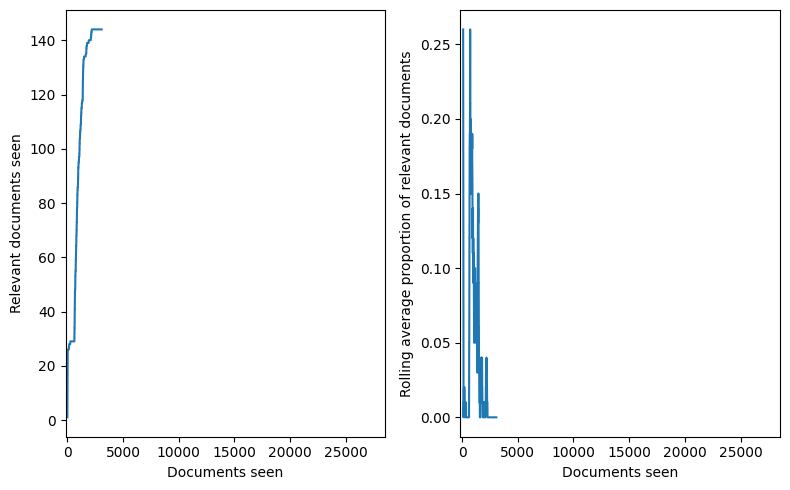

In [3]:
import matplotlib.pyplot as plt

# Here's the progress we are making so far
fig, axs = plt.subplots(1,2,figsize=(8,5), sharex=True)
df.relevant.cumsum().plot(ax=axs[0])
axs[0].set_xlabel("Documents seen")
axs[0].set_ylabel("Relevant documents seen")
#axs[0].plot(df.index*0.01,ls="--",lw=1,color="grey")

original_df = df.copy()

df.relevant.rolling(window=100).mean().plot(ax=axs[1])
axs[1].set_xlabel("Documents seen")
axs[1].set_ylabel("Rolling average proportion of relevant documents")
axs[0].set_xlim(xmax=df.shape[0])

#axs[1].axhline(0.01,ls="--",lw=1,color="grey")

fig.tight_layout()

{'batch_sizes': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
        1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200,
        2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3078]),
 'p': array([0.99275796, 0.99395475, 0.99435518, 0.98034768, 0.9664887 ,
        0.95277719, 0.99655908, 0.99999384, 0.99819292, 0.99920154,
        0.99912579, 0.99478427, 0.99897265, 0.99889523, 0.99667738,
        0.94279499, 0.99940403, 0.97403559, 0.91735713, 0.94841109,
        0.99371365, 0.98781561, 0.92595689, 0.86775756, 0.81301392,
        0.76153287, 0.71313145, 0.66763629, 0.62488317, 0.58471656,
        0.55508715])}

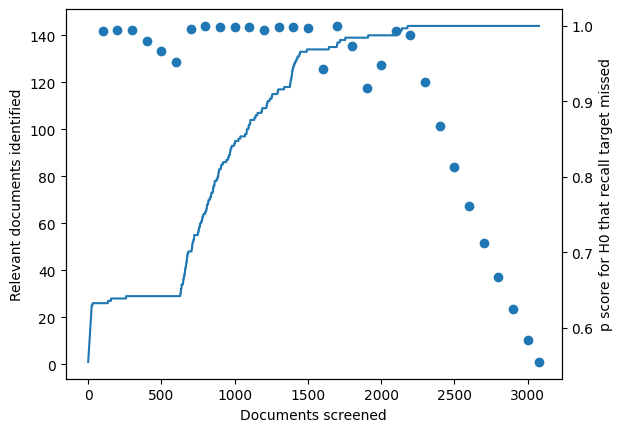

In [4]:
retrospective_h0(seen_df['relevant'], df.shape[0], recall_target=0.9, batch_size=100)


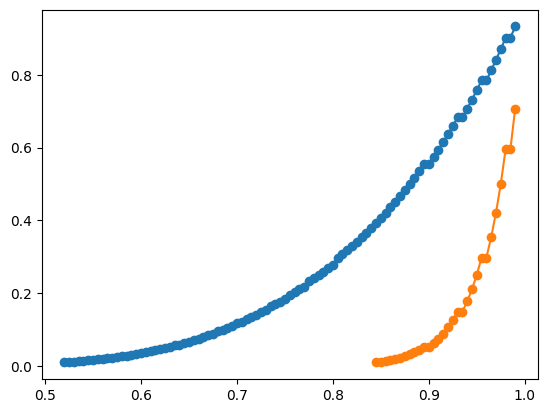

In [4]:
scores = recall_frontier(seen_df['relevant'], df.shape[0])
bias_scores_original = recall_frontier(seen_df['relevant'], df.shape[0], bias=5)

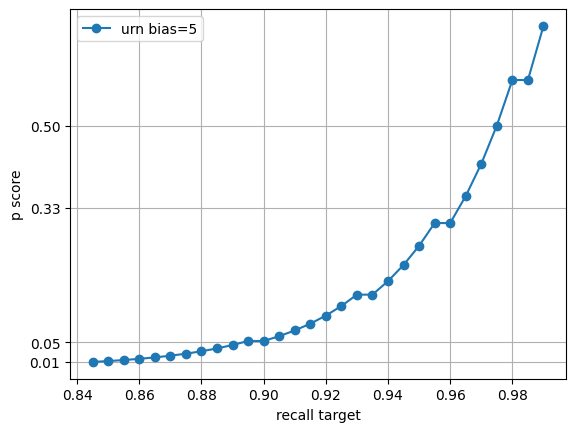

In [5]:
fig, ax = plt.subplots()
#ax.plot(scores['recall_target'], scores['p'], label='unbiased', marker='o')
ax.plot(bias_scores_original['recall_target'], bias_scores_original['p'], label='urn bias=5', marker='o')

ax.grid()
#ax.set_yscale('log')
ax.set_yticks([0.05,0.01,0.33,0.5])
ax.set_xlabel('recall target')
ax.set_ylabel('p score')
ax.legend()

## Update

In [6]:
django.db.connection.close()
# Get the query
q = Query.objects.get(pk=10997)
new_q = Query.objects.get(pk=11877)

dids = set(Doc.objects.filter(query__in=[new_q], content__iregex='\w').values_list('pk', flat=True))

import statistics

django.db.connection.close()

def mode_na(x):
    v, c = np.unique(x, return_counts=True)
    if v.shape[0] == 1:
        return v[0]
    idx = np.argsort(c)[::-1]
    if c[idx[0]] > c[idx[1]]:
        return v[idx[0]]
    else:
        return 3
    
columns = [
    'id',
    'PY',
    'content',
    'title',
    'tslug',
    'wosarticle__de',
    'wosarticle__wc'
]

# Majority ratings
dos = DocOwnership.objects.filter(
    #query__project=q.project, 
    query__in=[new_q],
    relevant__gt=0,
    doc__content__iregex='\w'
)

dodf = pd.DataFrame.from_dict(dos.order_by('finish').values(
    'id','doc_id','user__username','relevant'
))
dodf.loc[dodf['relevant']==2,'relevant'] = 0
dodf.loc[dodf['relevant']==3,'relevant'] = 3

seen_df = dodf.groupby('doc_id').agg(lambda x: mode_na(x)).reset_index()[['doc_id','relevant']].rename(columns={"doc_id":"id"})
seen_df['seen'] = 1
seen_df.loc[pd.isna(seen_df['relevant']),'seen'] = np.NaN

ddf = pd.DataFrame.from_dict(
    Doc.objects.filter(pk__in=seen_df['id']).values(*columns)
)
seen_df = pd.merge(ddf,seen_df)

print(seen_df.shape)

for l, v in zip(['yes','no','maybe'],[1,0,3]):
    n = seen_df[seen_df['relevant']==v].shape[0]
    print(f'{n} documents with label {l}')

seen_df['relevant'] = seen_df['relevant'].replace(3,1)
seen_df.head()

unseen_docs = Doc.objects.filter(
    id__in=dids,
    content__iregex='\w',
).exclude(pk__in=seen_df['id'])

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = np.NaN
unseen_df['seen'] = 0
unseen_df['random_sample'] = 0

print(unseen_df.shape)
unseen_df.head()

# Here are the labels in the order they were created
dos = (pd.DataFrame.from_dict(DocOwnership.objects.filter(query__in=[q,new_q], relevant__gt=0).order_by('id').values('id','doc_id'))
       .groupby('doc_id')
       .first()
       .sort_values('id')
       .reset_index()
       .reset_index()
       .drop(columns="id")
       .rename(columns={"doc_id":"id","index":"order"})
      )
dos.head()

seen_df = seen_df.merge(dos,how="left").sort_values('order').reset_index(drop=True)
seen_df.head()

df = pd.concat([seen_df, unseen_df]).reset_index(drop=True)
seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']!=1].index
print(df.shape)
df.head()

(1496, 9)
99 documents with label yes
1397 documents with label no
0 documents with label maybe
(5443, 10)
(6939, 11)


,id,PY,content,title,tslug,wosarticle__de,wosarticle__wc,relevant,seen,order,random_sample
0,5366504,2022.0,Background Voices for Food was a longitudinal ...,Evaluating a Food Pantry-Based Intervention to...,evaluatingafoodpantrybasedinterventiontoimprov...,Diet quality; Food security; Emergency food as...,None,0.0,1.0,59.0,NaN
1,5366374,2023.0,Background: The burden of obesity and chronic ...,"Perceived intrinsic, social, and environmental...",perceivedintrinsicsocialandenvironmentalbarrie...,Hispanic/Latino; language acculturation; obesi...,None,0.0,1.0,65.0,NaN
2,5378422,NaN,This natural experiment evaluated the effectiv...,Increasing the Selection of Low-Carbon-Footpri...,increasingtheselectionoflowcarbonfootprintentr...,None,None,1.0,1.0,630.0,NaN
3,5353952,NaN,We investigated the effect of health and envir...,The effect of information nudges on online pur...,theeffectofinformationnudgesononlinepurchaseso...,environment; grocery shopping; health; meatles...,[Agricultural Economics & Policy; Economics],1.0,1.0,675.0,NaN
4,4946556,NaN,Many cities in developing countries lack adequ...,Low-Cost Strategies to Improve Municipal Solid...,lowcoststrategiestoimprovemunicipalsolidwastem...,At-source segregation; Low-cost intervention; ...,[Economics; Environmental Studies],0.0,1.0,678.0,NaN


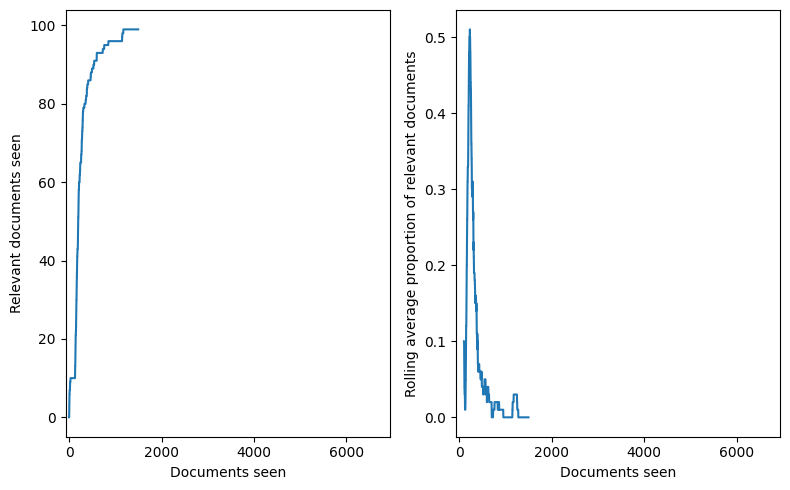

In [7]:
import matplotlib.pyplot as plt

# Here's the progress we are making so far
fig, axs = plt.subplots(1,2,figsize=(8,5), sharex=True)
df.relevant.cumsum().plot(ax=axs[0])
axs[0].set_xlabel("Documents seen")
axs[0].set_ylabel("Relevant documents seen")
#axs[0].plot(df.index*0.01,ls="--",lw=1,color="grey")

df.relevant.rolling(window=100).mean().plot(ax=axs[1])
axs[1].set_xlabel("Documents seen")
axs[1].set_ylabel("Rolling average proportion of relevant documents")
axs[0].set_xlim(xmax=df.shape[0])

#axs[1].axhline(0.01,ls="--",lw=1,color="grey")

fig.tight_layout()

{'batch_sizes': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
        1200, 1300, 1400, 1496]),
 'p': array([0.97983778, 0.99910979, 0.99864458, 0.99238041, 0.99226249,
        0.99826498, 0.83795741, 0.93099769, 0.91322353, 0.75987415,
        0.63030297, 0.94715357, 0.76687071, 0.61855953, 0.50138777])}

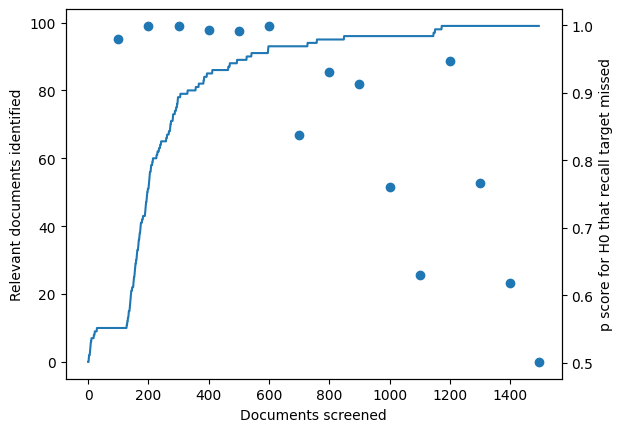

In [8]:
retrospective_h0(seen_df['relevant'], df.shape[0], recall_target=0.9, batch_size=100)


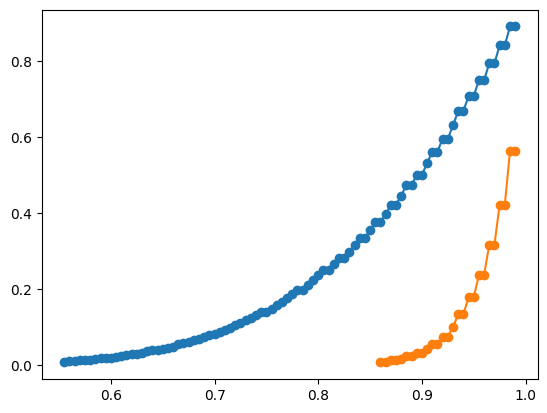

In [9]:
scores = recall_frontier(seen_df['relevant'], df.shape[0])
bias_scores = recall_frontier(seen_df['relevant'], df.shape[0], bias=5)

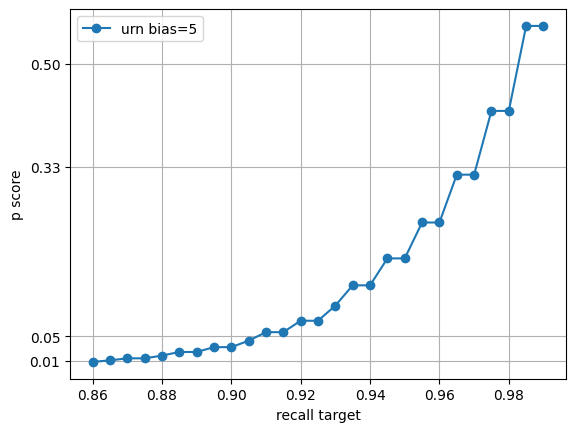

In [10]:
fig, ax = plt.subplots()
#ax.plot(scores['recall_target'], scores['p'], label='unbiased', marker='o')
ax.plot(bias_scores['recall_target'], bias_scores['p'], label='urn bias=5', marker='o')

ax.grid()
#ax.set_yscale('log')
ax.set_yticks([0.05,0.01,0.33,0.5])
ax.set_xlabel('recall target')
ax.set_ylabel('p score')
ax.legend()

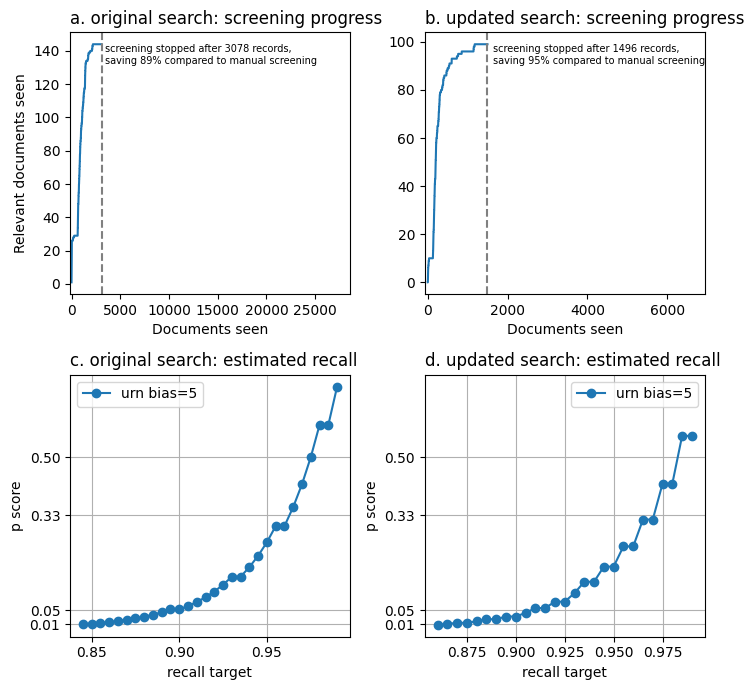

In [50]:
fig, axs = plt.subplots(2,2,figsize=(7.4,7))

N = original_df.shape[0]
original_df.relevant.cumsum().plot(ax=axs[0,0])
axs[0,0].set_xlabel("Documents seen")
axs[0,0].set_ylabel("Relevant documents seen")
axs[0,0].set_xlim(xmax=original_df.shape[0])
s = original_df.relevant.dropna().shape[0]
ws = (N-s) / N

axs[0,0].axvline(s, color='grey', ls='--')

axs[0,0].text(
    s*1.1,
    original_df.relevant.sum(),
    f'screening stopped after {s} records,\nsaving {ws:.0%} compared to manual screening',
    size=7,
    va='top'
)

df.relevant.cumsum().plot(ax=axs[0,1])
axs[0,1].set_xlabel("Documents seen")
#axs[0,1].set_ylabel("Relevant documents seen")
axs[0,1].set_xlim(xmax=df.shape[0])

s = df.relevant.dropna().shape[0]
ws = (N-s) / N

axs[0,1].axvline(s, color='grey', ls='--')

axs[0,1].text(
    s*1.1,
    df.relevant.sum(),
    f'screening stopped after {s} records,\nsaving {ws:.0%} compared to manual screening',
    size=7,
    va='top'
)

#axs[0,1].grid()
#axs[0,0].grid()

ax = axs[1,0]
ax.plot(bias_scores_original['recall_target'], bias_scores_original['p'], label='urn bias=5', marker='o')

ax.grid()
#ax.set_yscale('log')
ax.set_yticks([0.05,0.01,0.33,0.5])
ax.set_xlabel('recall target')
ax.set_ylabel('p score')
ax.legend()


ax = axs[1,1]
ax.sharey(axs[1,0])
ax.plot(bias_scores['recall_target'], bias_scores['p'], label='urn bias=5', marker='o')

ax.grid()
#ax.set_yscale('log')
ax.set_yticks([0.05,0.01,0.33,0.5])
ax.set_xlabel('recall target')
ax.set_ylabel('p score')
ax.legend()


axs[0,0].set_title('a. original search: screening progress', loc='left')
axs[0,1].set_title('b. updated search: screening progress', loc='left')

axs[1,0].set_title('c. original search: estimated recall', loc='left')
axs[1,1].set_title('d. updated search: estimated recall', loc='left')

fig.tight_layout()



## Merged

In [12]:
django.db.connection.close()
# Get the query
q = Query.objects.get(pk=10997)
new_q = Query.objects.get(pk=11877)

dids = set(Doc.objects.filter(query__in=[new_q,q], content__iregex='\w').values_list('pk', flat=True))

import statistics

django.db.connection.close()

def mode_na(x):
    v, c = np.unique(x, return_counts=True)
    if v.shape[0] == 1:
        return v[0]
    idx = np.argsort(c)[::-1]
    if c[idx[0]] > c[idx[1]]:
        return v[idx[0]]
    else:
        return 3
    
columns = [
    'id',
    'PY',
    'content',
    'title',
    'tslug',
    'wosarticle__de',
    'wosarticle__wc'
]

# Majority ratings
dos = DocOwnership.objects.filter(
    #query__project=q.project, 
    query__in=[new_q,q],
    relevant__gt=0,
    doc__content__iregex='\w'
)

dodf = pd.DataFrame.from_dict(dos.order_by('finish').values(
    'id','doc_id','user__username','relevant'
))
dodf.loc[dodf['relevant']==2,'relevant'] = 0
dodf.loc[dodf['relevant']==3,'relevant'] = 3

seen_df = dodf.groupby('doc_id').agg(lambda x: mode_na(x)).reset_index()[['doc_id','relevant']].rename(columns={"doc_id":"id"})
seen_df['seen'] = 1
seen_df.loc[pd.isna(seen_df['relevant']),'seen'] = np.NaN

ddf = pd.DataFrame.from_dict(
    Doc.objects.filter(pk__in=seen_df['id']).values(*columns)
)
seen_df = pd.merge(ddf,seen_df)

print(seen_df.shape)

for l, v in zip(['yes','no','maybe'],[1,0,3]):
    n = seen_df[seen_df['relevant']==v].shape[0]
    print(f'{n} documents with label {l}')

seen_df['relevant'] = seen_df['relevant'].replace(3,1)
seen_df.head()

unseen_docs = Doc.objects.filter(
    id__in=dids,
    content__iregex='\w',
).exclude(pk__in=seen_df['id'])

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = np.NaN
unseen_df['seen'] = 0
unseen_df['random_sample'] = 0

print(unseen_df.shape)
unseen_df.head()

# Here are the labels in the order they were created
dos = (pd.DataFrame.from_dict(DocOwnership.objects.filter(query__in=[q,new_q], relevant__gt=0).order_by('id').values('id','doc_id'))
       .groupby('doc_id')
       .first()
       .sort_values('id')
       .reset_index()
       .reset_index()
       .drop(columns="id")
       .rename(columns={"doc_id":"id","index":"order"})
      )
dos.head()

seen_df = seen_df.merge(dos,how="left").sort_values('order').reset_index(drop=True)
seen_df.head()

df = pd.concat([seen_df, unseen_df]).reset_index(drop=True)
seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']!=1].index
print(df.shape)
df.head()

(4301, 9)
234 documents with label yes
4067 documents with label no
0 documents with label maybe
(31001, 10)
(35302, 11)


,id,PY,content,title,tslug,wosarticle__de,wosarticle__wc,relevant,seen,order,random_sample
0,268305,2013.0,We show that two simple and nonintrusive 'nudg...,'Nudging' hotel guests to reduce food waste as...,nudginghotelgueststoreducefoodwasteasawinwinen...,Field experiment; Food waste; Behavioral econo...,[Economics],1.0,1.0,0.0,NaN
1,778080,2017.0,"Many countries strive to reduce food waste, wh...",Foodservice Composting Crowds Out Consumer Foo...,foodservicecompostingcrowdsoutconsumerfoodwast...,Food waste; composting; rebound effects; suppl...,[Agricultural Economics & Policy; Economics],1.0,1.0,1.0,NaN
2,1022233,2018.0,Promoting pro-environmental behaviour amongst ...,Using Behavioural Insights to Promote Food Was...,usingbehaviouralinsightstopromotefoodwasterecy...,pro-environmental behaviour; nudging; communit...,"[Psychology, Multidisciplinary]",1.0,1.0,2.0,NaN
3,1049060,2018.0,Changes in human diets hold significant greenh...,Carbon Label at a University Restaurant - Labe...,carbonlabelatauniversityrestaurantlabelimpleme...,Carbon labeling; Mitigation; Food consumption;...,[Ecology; Economics; Environmental Sciences; E...,1.0,1.0,3.0,NaN
4,1051383,2018.0,Reducing meat consumption is considered to hav...,Nudging to reduce meat consumption: Immediate ...,nudgingtoreducemeatconsumptionimmediateandpers...,Nudging; Field experiment; Meat consumption; C...,[Business; Economics; Environmental Studies],1.0,1.0,4.0,NaN


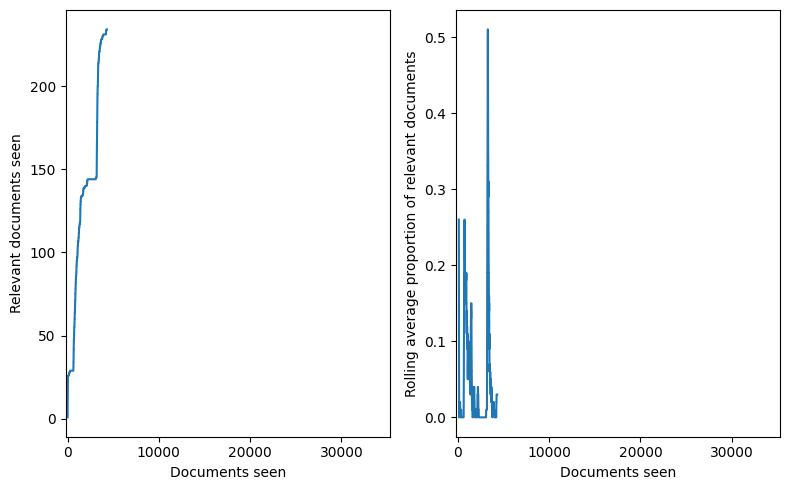

In [13]:
import matplotlib.pyplot as plt

# Here's the progress we are making so far
fig, axs = plt.subplots(1,2,figsize=(8,5), sharex=True)
df.relevant.cumsum().plot(ax=axs[0])
axs[0].set_xlabel("Documents seen")
axs[0].set_ylabel("Relevant documents seen")
#axs[0].plot(df.index*0.01,ls="--",lw=1,color="grey")

df.relevant.rolling(window=100).mean().plot(ax=axs[1])
axs[1].set_xlabel("Documents seen")
axs[1].set_ylabel("Rolling average proportion of relevant documents")
axs[0].set_xlim(xmax=df.shape[0])

#axs[1].axhline(0.01,ls="--",lw=1,color="grey")

fig.tight_layout()

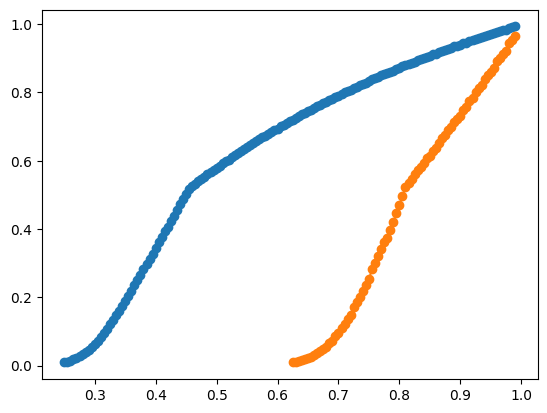

In [14]:
scores = recall_frontier(seen_df['relevant'], df.shape[0])
bias_scores = recall_frontier(seen_df['relevant'], df.shape[0], bias=5)

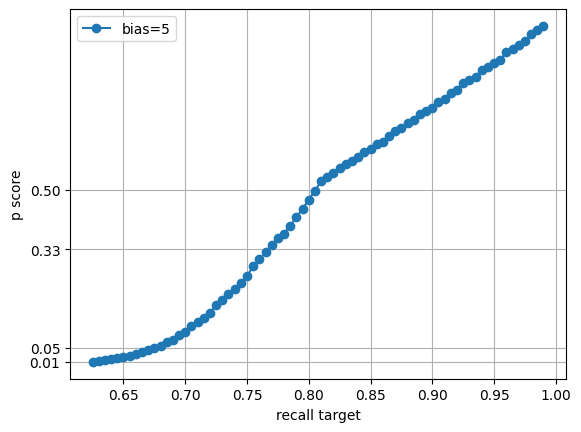

In [15]:
fig, ax = plt.subplots()
#ax.plot(scores['recall_target'], scores['p'], label='unbiased', marker='o')
ax.plot(bias_scores['recall_target'], bias_scores['p'], label='bias=5', marker='o')

ax.grid()
#ax.set_yscale('log')
ax.set_yticks([0.05,0.01,0.33,0.5])
ax.set_xlabel('recall target')
ax.set_ylabel('p score')
ax.legend()